In [1]:
import wandb
import yaml
from utilities.utils import correct_type_of_entry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
pd.set_option('display.max_rows', None)

/Users/mathieubazinet/.pyenv/versions/3.12.3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ignore_lr = False

In [3]:
dataset = "mnist"
sweep_config = "pretraining"
values_to_fetch = ['kl_bound', 'binomial_approximation_shah', 'p2l_bound', 'compression_set_size',
                   'validation_error', 'test_error', 'CE_kl_bound', "CE_min_val_catoni_bound",
                   'complement_loss', 'validation_loss', 'test_loss', '_runtime']

sweep_config_name = "./configs/sweep_configs/" + sweep_config + ".yaml"
with open(sweep_config_name) as file:
    sweep_configuration = yaml.safe_load(file)
    
hps = {}
for key, item in sweep_configuration['parameters'].items():
    if item.get('values', None) is not None:
        hps[key] = correct_type_of_entry(item['values'])

if ignore_lr:
    hps['training_lr'] = [0.001, 0.0001]
size_hyperparams = tuple([len(l) for l in hps.values()])

In [4]:
api = wandb.Api()
entity = "mathieu-bazinet"
project = "sweep" + dataset
runs = api.runs(entity + "/" + project)

In [5]:
new_runs = []
for run in runs:
    if run.createdAt[:-4] > '2024-09-24T12:42':
        new_runs.append(run)
runs = new_runs

In [6]:
hps
# results_matrix.shape

{'seed': [1, 2, 3, 4, 42],
 'prior_size': [0.1, 0.2, 0.5],
 'pretraining_epochs': [50, 100],
 'pretraining_lr': [0.01, 0.001, 0.0001],
 'dropout_probability': [0.1, 0.2],
 'training_lr': [0.001, 0.005, 0.0001]}

In [7]:
results_matrix = np.ones(((len(values_to_fetch),) + size_hyperparams))

for run_idx in range(len(runs)):
    run = runs[run_idx]
    if run.config['training_lr'] != 0.005 or not ignore_lr:
        for val_to_fetch_idx in range(len(values_to_fetch)):
            matrix_idx = tuple([val_to_fetch_idx] + [hps[key].index(run.config[key]) for key in hps.keys()])
            val_to_fetch = values_to_fetch[val_to_fetch_idx]
            results_matrix[matrix_idx] = run.summary[val_to_fetch]
from itertools import product

hp_list = list(hps.values())[1:]
params_product = list(product(*hp_list))
name_list = []
idx_list = []
for params in params_product:
    name = ""
    for p in params:
        name += str(p) + " "
    name_list.append(name[:-1])
    idx = ()
    for p_idx in range(len(params)):
        p_key = list(hps.keys())[1:][p_idx]
        idx += (hps[p_key].index(params[p_idx]),)
    idx_list.append(tuple(idx))

In [8]:
reshaped_matrix = results_matrix.mean(1).reshape(results_matrix.shape[0],np.prod(results_matrix.shape[2:])).T

mean_df = pd.DataFrame(reshaped_matrix, index=name_list, columns=values_to_fetch)
mean_df

,kl_bound,binomial_approximation_shah,p2l_bound,compression_set_size,validation_error,test_error,CE_kl_bound,CE_min_val_catoni_bound,complement_loss,validation_loss,test_loss,_runtime
0.1 50 0.01 0.1 0.001,0.352127,0.352041,0.127062,5939.2,0.193691,0.193762,3.764233,3.857538,0.461629,0.520778,0.517133,2037.201954
0.1 50 0.01 0.1 0.005,0.458112,0.458035,0.175823,8230.4,0.193504,0.192447,4.977358,5.069166,0.460625,0.571432,0.557218,2552.396916
0.1 50 0.01 0.1 0.0001,0.329773,0.329685,0.118833,5555.2,0.196363,0.194695,3.573397,3.673132,0.475925,0.517555,0.512739,2350.314251
0.1 50 0.01 0.2 0.001,0.353470,0.353384,0.127741,5971.2,0.193701,0.193100,3.779415,3.872324,0.461600,0.522958,0.515490,2030.378088
0.1 50 0.01 0.2 0.005,0.458112,0.458035,0.175823,8230.4,0.193504,0.192447,4.977358,5.069166,0.460625,0.571432,0.557218,2560.730178
0.1 50 0.01 0.2 0.0001,0.329773,0.329685,0.118833,5555.2,0.196363,0.194695,3.573397,3.673132,0.475925,0.517555,0.512739,2341.157793
0.1 50 0.001 0.1 0.001,0.214693,0.214588,0.062753,2880.0,0.011230,0.011348,2.472033,2.471617,0.000030,0.081253,0.075731,797.020437
0.1 50 0.001 0.1 0.005,0.652792,0.653627,0.364699,17203.2,0.091673,0.088168,7.531131,7.565455,0.145721,1.058038,0.994486,6777.287383
0.1 50 0.001 0.1 0.0001,0.103780,0.103664,0.023853,1068.8,0.012107,0.011648,1.209370,1.208847,0.002201,0.050163,0.042957,352.330533
0.1 50 0.001 0.2 0.001,0.213173,0.213068,0.062336,2860.8,0.010724,0.010422,2.454661,2.454367,0.000044,0.080642,0.075764,753.322974


In [9]:
std_matrix = results_matrix.std(1).reshape(results_matrix.shape[0],np.prod(results_matrix.shape[2:])).T
std_df = pd.DataFrame(std_matrix, index=name_list, columns=values_to_fetch)

/var/folders/t7/t2tk8_dd3vsc811yh2mdwbbh0000gp/T/ipykernel_26411/520738583.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


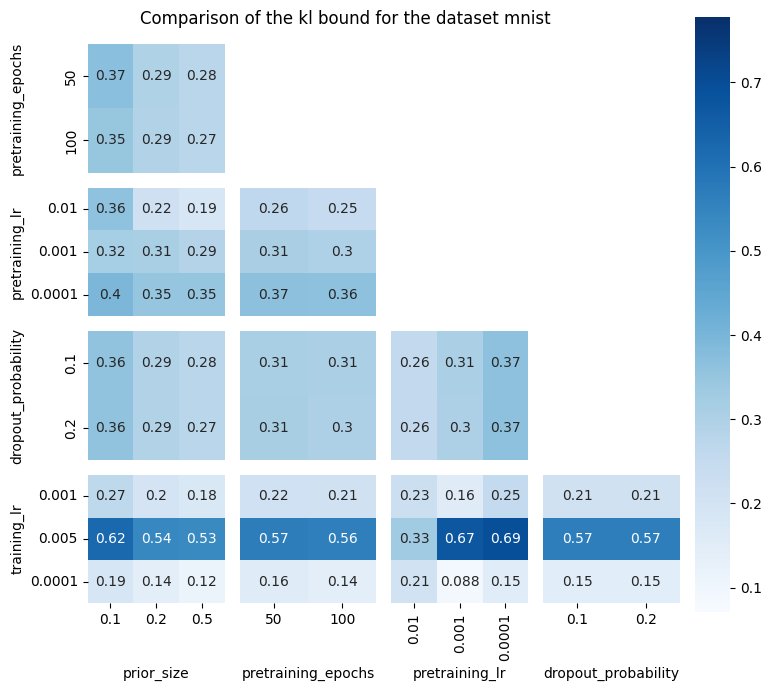

In [10]:
index = 0
mean_arr = results_matrix.mean(1)[index]
key_list = list(hps.keys())[1:]

fig, axs = plt.subplots(4, 4, figsize=(7,7))
for i in range(0,len(key_list)-1):
    for j in range(i+1,len(key_list)-1):
        fig.delaxes(axs[i, j])

fig.subplots_adjust(right=0.8)

cmap = 'Blues'
vmax = mean_arr.max()
vmin = mean_arr.min()

for i in range(0,len(key_list)-1):
    for j in range(i+1,len(key_list)):
        index_list = list(range(len(key_list)))
        index_list.remove(i)
        index_list.remove(j)
        index_list = index_list[::-1]
        new_arr = mean_arr.mean(index_list[0])
        for k in range(1,len(index_list)):
            new_arr = new_arr.mean(index_list[k])
        df = pd.DataFrame(new_arr.T, index=hps[key_list[j]], columns=hps[key_list[i]])
        if i != 0:
            yticklabels = False
        else:
            yticklabels = True
            axs[j-1,i].set(xlabel=key_list[j])
        if j+1 != len(key_list):
            xticklabels = False
        else:
            xticklabels = True
            axs[j-1,i].set(ylabel=key_list[i])
            
        if j == 1 and i == 0:
            cbar_ax = fig.add_axes([1, 0.12, 0.05, 0.85])
            cbar = True
        else:
            cbar_ax = None
            cbar = False
        
        sn.heatmap(df, annot=True, ax=axs[j-1,i], cbar=cbar, vmin=vmin, vmax=vmax,
                cmap=cmap, xticklabels=xticklabels, yticklabels=yticklabels, cbar_ax=cbar_ax)
        if j+1 == len(key_list):
            axs[j-1, i].set(xlabel=key_list[i])
        if i == 0:
            axs[j-1, i].set(ylabel=key_list[j])

fig.suptitle(f"Comparison of the {values_to_fetch[index].replace("_", " ")} for the dataset {dataset}")
# # Layout so plots do not overlap
fig.tight_layout()
fig.align_labels()

plt.savefig(f"./results/mnist/{dataset}_{values_to_fetch[index]}_{"ignore_lr_" if ignore_lr else ""}heatmaps.jpg",bbox_inches='tight')

Validation error: 0.009287539683282376 KL bound 0.11196740996092558
The best bound for run 42 happens at 0 datapoints with a bound value of 0.015240831966857101
The best bound for run 4 happens at 0 datapoints with a bound value of 0.01383238976994503
The best bound for run 3 happens at 0 datapoints with a bound value of 0.015403745304398616
The best bound for run 2 happens at 0 datapoints with a bound value of 0.015766104069127068
The best bound for run 1 happens at 0 datapoints with a bound value of 0.015396679472358257
Mean value of the best bounds taken separately : 0.015127950116537215


Text(0.5, 1.0, 'Comparison of the behavior of the bound on mnist')

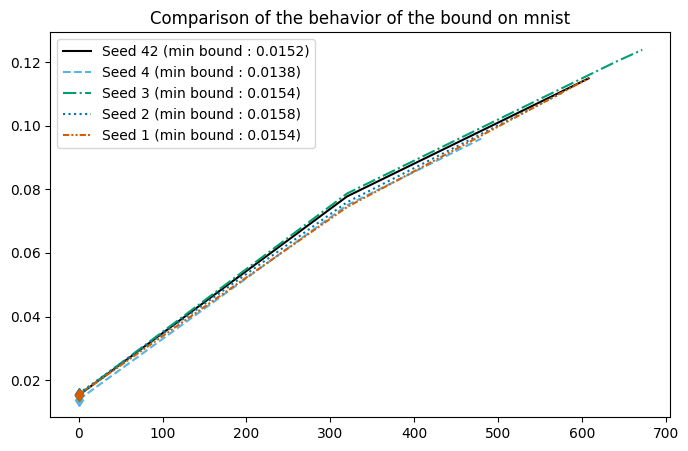

In [11]:
from bounds.real_valued_bounds import compute_epsilon, kl_bound
from copy import deepcopy

new_config = deepcopy(hps)
new_config.pop("seed", None)

best_params = correct_type_of_entry(mean_df.index[mean_df['validation_error'].argmin()].split())

print("Validation error:", mean_df['validation_error'].min(), "KL bound", mean_df.loc[mean_df.index[mean_df['validation_error'].argmin()]]['kl_bound'])
# model_type = "cnn"
# training_lr = 0.01
# dropout_probability = 0.1

# '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'
# linestyles = ["solid", "dotted", "dashed", "dashdot", "dashdotdotted"]
linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1, 1, 1))]
colors = ["#000000", "#56B4E9", "#009E73", "#0072B2", "#D55E00"]

plt.figure(figsize=(8,5))
run_list = []

for run in runs:
    counter = 0
    for idx, key_item in enumerate(new_config.items()):
        key = key_item[0]
        if run.config[key] == best_params[idx]:
            counter += 1
    if counter == len(new_config.keys()):
        run_list.append(run)

all_seeds_bounds = []
max_length_run = 0
max_comp_sizes = []
counter = 0
for run in run_list:
    history = run.scan_history(keys=["kl_bound"])
    losses = [row["kl_bound"] for row in history]
    val_sizes = run.config['data_groupsize'] * run.config['log_iterations']
    compression_sizes = np.array(list(range(0,len(losses)-1))) * val_sizes
    compression_sizes = np.append(compression_sizes, run.summary['compression_set_size'])

    if compression_sizes.shape[0] > max_length_run:
        max_length_run = compression_sizes.shape[0]
        max_comp_sizes = compression_sizes
        
    plt.plot(compression_sizes, losses,'d',
             markevery=[np.array(losses).argmin()],
             linestyle=linestyles[counter], #ms=8, #mew=1.2,
             color=colors[counter],
             label=f"Seed {run.config['seed']} (min bound : {min(losses):.4f})")
    best_idx = np.array(losses).argmin()
    print(f"The best bound for run {run.config['seed']} happens at {compression_sizes[best_idx]} datapoints with a bound value of {losses[best_idx]}")
    all_seeds_bounds.append(losses)
    counter += 1

print(f"Mean value of the best bounds taken separately : {sum([min(l) for l in all_seeds_bounds])/5}")
plt.legend(markerscale=0)
plt.title(f"Comparison of the behavior of the bound on {dataset}")
# plt.savefig(f"./results/{dataset}_min_bound_comparison.jpg")


In [12]:
val_of_interest = "kl_bound"
best_params = correct_type_of_entry(mean_df.index[mean_df[val_of_interest].argmin()].split())
print(best_params)
best_val_arr = mean_df.loc[mean_df.index[mean_df[val_of_interest].argmin()]]
std_val_arr = std_df.loc[mean_df.index[mean_df[val_of_interest].argmin()]]
print(f"Validation error: {best_val_arr['validation_error']:.4f}±{std_val_arr['validation_error']:.4f} "
      f'Test error : {best_val_arr['test_error']:.4f}±{std_val_arr['test_error']:.4f} ', 
      f"KL bound : {best_val_arr['kl_bound']:.4f}±{std_val_arr['kl_bound']:.4f} ",
    f'binomial : {best_val_arr['binomial_approximation_shah']:.4f}±{std_val_arr['binomial_approximation_shah']:.4f} ',
     f'P2L bound : {best_val_arr['p2l_bound']:.4f}±{std_val_arr['p2l_bound']:.4f} ', 
      f'compression set size : {best_val_arr['compression_set_size']:.4f}±{std_val_arr['compression_set_size']:.4f} ',
f"Complement loss: {best_val_arr['complement_loss']:.4f}±{std_val_arr['complement_loss']:.4f} "
    f"Validation loss: {best_val_arr['validation_loss']:.4f}±{std_val_arr['validation_loss']:.4f} "
      f'Test loss : {best_val_arr['test_loss']:.4f}±{std_val_arr['test_loss']:.4f} ', 
    f"CE KL bound: {best_val_arr['CE_kl_bound']:.4f}±{std_val_arr['CE_kl_bound']:.4f} "
      f'CE Catoni bound : {best_val_arr['CE_min_val_catoni_bound']:.4f}±{std_val_arr['CE_min_val_catoni_bound']:.4f} ',
    f"Runtime : {best_val_arr['_runtime']:.4f}±{std_val_arr['_runtime']:.4f}"
)

[0.5, 100.0, 0.001, 0.1, 0.0001]
Validation error: 0.0107±0.0010 Test error : 0.0114±0.0007  KL bound : 0.0711±0.0022  binomial : 0.0708±0.0022  P2L bound : 0.0152±0.0006  compression set size : 326.4000±12.8000  Complement loss: 0.0014±0.0006 Validation loss: 0.0535±0.0095 Test loss : 0.0467±0.0056  CE KL bound: 0.8279±0.0256 CE Catoni bound : 0.8269±0.0256  Runtime : 270.8941±57.6181


In [ ]:
from bounds.classical_bounds import binomial_approximation
from bounds.bound_utils import zeta, log_binomial_coefficient
from time import sleep
from tqdm import tqdm

new_vals_to_fetch = ['kl_bound',"compression_set_size",  "complement_error", 'validation_error', 'test_error',]
early_stop_result_matrix = np.ones(((len(new_vals_to_fetch)+1,) + size_hyperparams))
    
for run_idx in tqdm(range(len(runs))):
    sleep(5)
    run = runs[run_idx]
    kl_history = run.scan_history(keys=["kl_bound"])
    kl_list = [row["kl_bound"] for row in kl_history]
    kl_idx = np.argmin(kl_list)
    
    val_sizes = run.config['data_groupsize'] * run.config['log_iterations']
    compression_sizes = np.array(list(range(1,len(kl_list)))) * val_sizes
    compression_sizes = np.append(compression_sizes, run.summary['compression_set_size'])
    
    for val_to_fetch_idx in range(len(new_vals_to_fetch)):
        matrix_idx = tuple([val_to_fetch_idx] + [hps[key].index(run.config[key]) for key in hps.keys()])
        val_to_fetch = new_vals_to_fetch[val_to_fetch_idx]
        history = run.scan_history(keys=[val_to_fetch])
        losses = [row[val_to_fetch] for row in history]
        if val_to_fetch == "validation_error" and len(losses) == 1:
            history = run.scan_history(keys=["val_error"])
            losses = [row["val_error"] for row in history]
            losses.append(run.summary["validation_error"])
        if val_to_fetch == "compression_set_size":
            losses = compression_sizes
        early_stop_result_matrix[matrix_idx] = losses[kl_idx]

    matrix_idx = tuple([hps[key].index(run.config[key]) for key in hps.keys()])
    complement_error = early_stop_result_matrix[(new_vals_to_fetch.index('complement_error'),) + matrix_idx]
    m = early_stop_result_matrix[(new_vals_to_fetch.index('compression_set_size'),) + matrix_idx]
    n = run.summary['train_set_size']
    k = complement_error * (n-m)
    
    log_delta = np.log(zeta(m)*run.config['delta']) - log_binomial_coefficient(n,m)
    delta_prime = np.exp(log_delta)
    early_stop_result_matrix[(-1,) + matrix_idx] = binomial_approximation(k, n-m, log_delta)

  3%|████▊                                                                                                                                             | 18/540 [02:08<1:01:55,  7.12s/it]

In [13]:
early_stop_matrix = early_stop_result_matrix.mean(1).reshape(early_stop_result_matrix.shape[0],np.prod(early_stop_result_matrix.shape[2:])).T
l = deepcopy(new_vals_to_fetch)
l.append("binomial_approximation_shah")
mean_early_stop_df = pd.DataFrame(early_stop_matrix, index=name_list, columns=l)
mean_early_stop_df.to_csv(f"./results/mnist/mean_{project}.csv")
mean_early_stop_df

,kl_bound,compression_set_size,complement_error,validation_error,test_error,binomial_approximation_shah
0.1 50 0.01 0.1 0.001,0.117759,1088.0,0.020230,0.033071,0.032000,0.184228
0.1 50 0.01 0.1 0.005,0.131504,896.0,0.032107,0.039915,0.040041,0.213667
0.1 50 0.01 0.1 0.0001,0.099341,320.0,0.045649,0.050729,0.048380,0.210562
0.1 50 0.01 0.2 0.001,0.120586,1088.0,0.021775,0.033424,0.033477,0.189458
0.1 50 0.01 0.2 0.005,0.139785,1024.0,0.031543,0.043130,0.042402,0.219838
0.1 50 0.01 0.2 0.0001,0.095175,320.0,0.042920,0.046858,0.045471,0.203185
0.1 50 0.001 0.1 0.001,0.074848,448.0,0.020879,0.025813,0.025093,0.144814
0.1 50 0.001 0.1 0.005,0.115413,768.0,0.027059,0.033292,0.031774,0.188517
0.1 50 0.001 0.1 0.0001,0.063331,320.0,0.021613,0.024065,0.024659,0.137265
0.1 50 0.001 0.2 0.001,0.074606,384.0,0.024325,0.029256,0.027263,0.151583


In [14]:
early_stop_std = early_stop_result_matrix.std(1).reshape(early_stop_result_matrix.shape[0],np.prod(early_stop_result_matrix.shape[2:])).T
std_early_stop_df = pd.DataFrame(early_stop_std, index=name_list, columns=l)
mean_early_stop_df.to_csv(f"./results/mnist/std_{project}.csv")

In [21]:
val_of_interest = "kl_bound"
best_params = correct_type_of_entry(mean_early_stop_df.index[mean_early_stop_df[val_of_interest].argmin()].split())
print(best_params)
best_val_arr = mean_early_stop_df.loc[mean_early_stop_df.index[mean_early_stop_df[val_of_interest].argmin()]]
std_val_arr = std_early_stop_df.loc[mean_early_stop_df.index[mean_early_stop_df[val_of_interest].argmin()]]
print(f"Complement error: {best_val_arr['complement_error']:.4f}±{std_val_arr['complement_error']:.4f} ",
    f"Validation error: {best_val_arr['validation_error']:.4f}±{std_val_arr['validation_error']:.4f} "
      f'Test error : {best_val_arr['test_error']:.4f}±{std_val_arr['test_error']:.4f} ', 
      f"KL bound : {best_val_arr['kl_bound']:.4f}±{std_val_arr['kl_bound']:.4f} ",
    f'binomial : {best_val_arr['binomial_approximation_shah']:.4f}±{std_val_arr['binomial_approximation_shah']:.4f} ',
     # f'P2L bound : {best_val_arr['p2l_bound']:.4f}±{std_val_arr['p2l_bound']:.4f} ', 
      f'compression set size : {best_val_arr['compression_set_size']:.4f}±{std_val_arr['compression_set_size']:.4f} ',
    # f"Validation loss: {best_val_arr['validation_loss']:.4f}±{std_val_arr['validation_loss']:.4f} "
      # f'Test loss : {best_val_arr['test_loss']:.4f}±{std_val_arr['test_loss']:.4f} ', 
    # f"CE KL bound: {best_val_arr['CE_kl_bound']:.4f}±{std_val_arr['CE_kl_bound']:.4f} "
      # f'CE Catoni bound : {best_val_arr['CE_min_val_catoni_bound']:.4f}±{std_val_arr['CE_min_val_catoni_bound']:.4f} ',
    # f"Runtime : {best_val_arr['_runtime']:.4f}±{std_val_arr['_runtime']:.4f}"
)

[0.5, 100.0, 0.001, 0.1, 0.0001]
Complement error: 0.0048±0.0044  Validation error: 0.0090±0.0027 Test error : 0.0115±0.0012  KL bound : 0.0350±0.0296  binomial : 0.0958±0.0221  compression set size : 320.0000±0.0000 
